<h1 style="font-size:1.8em">Projet 3 - Concevez une application au service de la santé publique</h1>


# Objectifs

1) Proposer une idée application en lien avec la nutrition
- Netoyage de données
- Analyse exploratoire  
- Présentation d'une idée d'application 

## Données à notre disposition

1) **fr.openfoodfacts.org.products.csv**  
- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.
2) **Definition_variables.txt**  
- Fichier text contenant les définitions des variables

## Analyse exploratoire

**1) Analyses univariées**
- fonction describe()   

**2) Analyses bivariées**
- Graphiques   
- Matrice des corrélations    

**3) Analyses multivariées**  
- ACP  (Analyse en composante principale)  
- ANOVA (Analysis of variance)  

## Présentation d'une idée d'application 

1) Une analyse à chaque graphique présentée  
2) Si on a le temps -> Mettre en oeuvre un algo machine learning (KNN)

- Pouvons nous regrouper les articles par catégories? Pays? Mots clés
- Pouvons nous valoriser ces informations?
(Utiliser Kaggle si on n'a pas d'inspiration) 

## Exemples

1) David - Nutrisport (Indicateurs pour les sportifs)
- Qte énergie, protéines, acides gras  
- Photo code barre -> Score nutrisport (Entre A et E)  
- Recommendations produits même catégorie  


2) Aurélia - Choisir le bon produit parmi un groupe de même catégorie de produit)
- Reconnaitre la catégorie du produit      
- Récupérer les informations nutritionnelles  - Photo de l'étiquette du produit  
- Recommandations produits même catégorie

## Livrables 

1) Un notebook netoyage
2) Un notebook exploration
3) Un powerpoint pour la présentation

# Fonctions (pour ne pas allourdir le fichier)

In [1]:
import pandas as pd
pd.options.display.max_columns = None

## Types mixtes colonnes

### recuperer_indices_colonnes_mixtes(df, indices_colonnes)

On récupère les indices pour lequel les colonnes sont mixtes, sauf quelques exceptions: 
1) On exclut le int + float (sans string) si les floats sont tous des nan
2) On exclut le string + float (sans int) si les floats sont tous des nan

In [2]:
import numpy as np

def recuperer_indices_colonnes_mixtes(df, indices_colonnes):
    mixed_columns = []
    for col in df.columns[indices_colonnes]:
        unique_types = {type(x) for x in df[col]}
        if len(unique_types) > 1:
            float_count = 0
            nan_count = 0
            for x in df[col]:
                if isinstance(x, float):
                    float_count += 1
                    if np.isnan(x):
                        nan_count += 1
            # Condition 1 - Exclure int + float (pas string) si les floats sont tous des nan
            if int in unique_types and not str in unique_types and float in unique_types and nan_count == float_count:
                continue
            # Condition 2 - Exclure string + float (pas int) si tout les floats sont des nan
            if str in unique_types and not int in unique_types and float in unique_types and nan_count == float_count:
                continue
            mixed_columns.append(col)
    mixed_columns_index = [df.columns.get_loc(col) for col in mixed_columns]        
    return mixed_columns_index

### analyse_colonnes_mixtes(df, indices_colonnes)

On affiche une analyse sur les colonnes mixtes, exemple: 
 
Colonne 0 (code):  
  Type : <class 'int'>, Exemple (ligne 209888): 3256220711258, Nombre de lignes : 282624  
  Type : <class 'str'>, Exemple (ligne 273551): 5052003557963, Nombre de lignes : 38125  
  Type : <class 'float'>, Exemple (ligne 189250): nan, Nombre de lignes : 23  

In [3]:
import random

def analyse_colonnes_mixtes(df, indices_colonnes):
    for colonne in indices_colonnes:
        if colonne < len(df.columns):
            resultat = df.iloc[:, colonne].apply(lambda x: type(x)).value_counts().reset_index()
            resultat.columns = ['Type', 'Nombre_de_lignes']

            nom_colonne = df.columns[colonne]
            print(f"Colonne {colonne} ({nom_colonne}):")

            for index, row in resultat.iterrows():
                type_donnee = row['Type']
                lignes_type = df[df.iloc[:, colonne].apply(type) == type_donnee].index.tolist()
                exemple_au_hasard = random.choice(lignes_type)
                print(f"  Type : {type_donnee}, Exemple (ligne {exemple_au_hasard}): {df.iloc[exemple_au_hasard, colonne]}, Nombre de lignes : {row['Nombre_de_lignes']}")

            print("\n")

### convertir_strings_en_int(df, indices_colonnes)

On convertit les strings en int, on ne touche pas aux float

In [4]:
def convertir_strings_en_int(df, indices_colonnes):
    for col in df.columns[indices_colonnes]:
        has_int = False
        has_str = False
        has_float = False
        
        for val in df[col]:
            if isinstance(val, int):
                has_int = True
            elif isinstance(val, str):
                has_str = True
            elif isinstance(val, float):
                has_float = True
                
            if has_int and has_str and has_float:
                break
                
        if has_int and has_str:
            # Convertir les valeurs en entier en utilisant une fonction pour gérer les exceptions
            df[col] = df[col].apply(lambda x: int(x) if (isinstance(x, str) and str(x).isdigit()) or isinstance(x, int) else x)

## Clustering

### Clustering lignes (K-means)

Algorithme de clustering non supervisé qui vise à partitionner un ensemble de données en k groupes distincts (ou clusters) en minimisant la somme des distances entre les points et leur centroïde (le centre du cluster) respectif. L'algorithme fonctionne de la manière suivante :

1) Sélectionner k points initiaux (généralement de manière aléatoire) comme centroïdes de départ.  
2) Attribuer chaque point de l'ensemble de données au centroïde le plus proche, créant ainsi k groupes.  
3) Mettre à jour les centroïdes en calculant la moyenne des points attribués à chaque groupe.  
4) Répéter les étapes 2 et 3 jusqu'à ce que les centroïdes ne changent plus ou que le nombre d'itérations prédéterminé soit atteint.  

#### Trouver la bonne valeur de k (cluster optimal)

Pour trouver le bon k, nous utilisons **la méthode du coude**:  
- **La méthode du coude** est une technique couramment utilisée pour estimer le nombre optimal de clusters (k) dans un algorithme de k-means. Elle consiste à effectuer plusieurs essais de k-means avec différentes valeurs de k et à calculer la somme des erreurs quadratiques (inertie) pour chaque essai. En traçant ces valeurs en fonction de k, on obtient une courbe en forme de coude. Le point d'inflexion de cette courbe, c'est-à-dire l'endroit où la courbe se plie, indique une estimation du nombre optimal de clusters.

- Utiliser le **maximum de la dérivée seconde** est une technique qui peut être utilisée pour affiner l'estimation du nombre optimal de clusters obtenue avec la méthode du coude. Cette méthode consiste à calculer la dérivée seconde de la courbe des erreurs quadratiques par rapport à k et à identifier le point où cette dérivée seconde atteint un maximum. Ce point correspond généralement à un changement abrupt dans la courbe, indiquant un bon choix pour le nombre de clusters.

**Attention** -> Personellement je préfère rajouter + 1 au nombre obtenu pour être sur de ne pas perdre trop d'informations.

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")
from tqdm import tqdm

def nombre_optimal_clusters(df, nb_k = 10):
    # Sélectionner uniquement les colonnes quantitatives
    df_quant = df.select_dtypes(include=[np.number])

    # Calcul de la somme des distances intra-clusters pour différentes valeurs de k
    SSE = []
    for cluster in tqdm(range(1, nb_k+1)):
        kmeans = KMeans(n_clusters=cluster, n_init=10, init='k-means++')
        kmeans.fit(df_quant)
        SSE.append(kmeans.inertia_)

     # Conversion des résultats en dataframe
    frame = pd.DataFrame({'Cluster': range(1, nb_k+1), 'SSE': SSE})

    # Calcul de la première et de la seconde dérivée de la SSE
    diff = np.diff(frame['SSE'])
    diff_diff = np.diff(diff)

    # Trouver le point "coude"
    elbow_index = np.argmax(diff_diff) + 2 +1

    # Tracer les résultats
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(frame['Cluster'], frame['SSE'], marker='o', label='Inertie')
    ax1.axvline(elbow_index, color='red', linestyle='--', label="Point 'coude'")
    ax1.plot(range(2, nb_k), diff_diff, marker='x', color='green', linestyle=':', label='Dérivée Seconde')
    ax1.set_xlabel('Nombre de clusters')
    ax1.set_ylabel('Inertie / Dérivée Seconde')
    ax1.set_xticks(np.arange(1, nb_k+1, step=1))
    ax1.legend(loc='best')

    fig.tight_layout()
    fig.suptitle("Analyse de l'inertie pour différentes valeurs de k", fontsize=16, y=1.05)
    plt.show()


    # Afficher le nombre optimal de clusters
    print("Le nombre optimal de clusters est: ", elbow_index)
    
    return elbow_index

#### Implémentation k-means sur DataFrame

Une fois qu'on a trouvé la bonne valeur de k, nous allons implémenter cet algorithme dans un DataFrame df

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def clustering_kmeans(df, nb_k):
    # Séparation des colonnes qualitatives et quantitatives
    colonnes_qualitatives = df.select_dtypes(include='object')
    colonnes_quantitatives = df.select_dtypes(exclude='object')

    # Normalisation des colonnes quantitatives
    scaler = StandardScaler()
    colonnes_quantitatives_normalisees = scaler.fit_transform(colonnes_quantitatives)

    # Clustering k-means
    kmeans = KMeans(n_clusters=nb_k, n_init = 10)
    clusters = kmeans.fit_predict(colonnes_quantitatives_normalisees)

    # Ajout des clusters au DataFrame d'origine
    df_cluster = df.copy()
    df_cluster['cluster'] = clusters

    # Réorganisation des colonnes pour placer 'cluster' en première position
    colonne_cluster = df_cluster.pop('cluster')
    df_cluster.insert(0, 'cluster', colonne_cluster)

    return df_cluster

### Clustering colonnes (ACP = Analyse en composante principale)

Technique statistique utilisée pour réduire la dimensionnalité d'un ensemble de données (colonnes). Elle permet de transformer un ensemble de variables corrélées en un ensemble de nouvelles variables non corrélées appelées "composantes principales".

L'objectif de l'ACP est de trouver les directions dans l'espace des données qui expliquent la plus grande variance possible, ce qui signifie que les composantes principales sont ordonnées en fonction de l'importance décroissante de leur contribution à la variance totale des données. Les premières composantes principales expliquent une grande partie de la variance, tandis que les dernières composantes principales expliquent une très faible partie de la variance.

#### Plot ACP

Ce code permet de créer un plot ACP sur (PC1, PC2) ou (PC2,PC3)... le choix est le notre.  
De plus, il affiche un dataframe qui affichera les valeurs des projections des colonnes sur PC1, PC2...

In [7]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def plot_PCA(df, composante_principale_x, composante_principale_y):
    # Sélectionner les colonnes quantitatives
    df = df.select_dtypes(include=[float])
    
    # Normaliser les données
    X = StandardScaler().fit_transform(df)
    
    # Effectuer l'ACP
    n_components = max(composante_principale_x, composante_principale_y)
    pca = PCA(n_components=n_components)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    # Standardiser les points dans l'espace des axes principaux
    X_pca_standardized = X_pca / np.sqrt(pca.singular_values_)
    
    # Créer le plot cercle des corrélations
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown','teal', 'black', 'magenta', 'lime', 'olive', 'silver']
    
    texts = []
    for i in range(len(pca.components_[composante_principale_x-1])):
        x = pca.components_[composante_principale_x-1][i]
        y = pca.components_[composante_principale_y-1][i]
        point = ax.scatter(x, y, color=colors[i % len(colors)])
        texts.append(ax.text(x, y, df.columns[i], color=colors[i % len(colors)]))
        
    circle = plt.Circle((0, 0), 1, color='black', fill=False)
    ax.add_artist(circle)
    
    explained_variance_ratio_x = pca.explained_variance_ratio_[composante_principale_x-1] * 100
    explained_variance_ratio_y = pca.explained_variance_ratio_[composante_principale_y-1] * 100
    
    plt.xlabel(f'PC{composante_principale_x} ({explained_variance_ratio_x:.2f}%)', fontsize=16, labelpad=10)
    plt.ylabel(f'PC{composante_principale_y} ({explained_variance_ratio_y:.2f}%)', fontsize=16)
    
    plt.suptitle(f'Cercle des corrélations (PC{composante_principale_x} vs PC{composante_principale_y})', y=0.91, fontsize=16)
    
    # Ajuster les marges pour éviter les coupures des textes
    plt.subplots_adjust(bottom=0.2)
    
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    
    adjust_text(texts)
    ax.grid(True, linestyle='dotted')

    plt.show()
    
    # Créer un DataFrame pour afficher les projections des colonnes sur les composantes principales spécifiées
    components = pca.components_[[composante_principale_x-1, composante_principale_y-1]]
    index = [f'PC{composante_principale_x}', f'PC{composante_principale_y}']
    df_pca = pd.DataFrame(components, columns=df.columns, index=index).T
    df_pca = df_pca.sort_values(by=f'PC{composante_principale_x}', ascending=False)

    display(df_pca)



#### Heatmap corrélations entre les colonnes et les composantes principales

Ce code cré une Heatmap et print les corrélations les plus fortes entre les ACP et les colonnes selon un seuil que l'on peut choisir

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def analyse_PCA(df, seuil_correlations=0.6):
    # Sélectionner uniquement les colonnes quantitatives
    df_quant = df.select_dtypes(include=[float])

    # Standardiser les données
    scaler = StandardScaler()
    df_quant_std = scaler.fit_transform(df_quant)

    # Appliquer l'ACP
    pca = PCA()
    pca_result = pca.fit_transform(df_quant_std)

    # Créer un nouveau DataFrame avec les résultats de l'ACP
    principal_components = [f'PC{i}' for i in range(1, len(pca.components_) + 1)]
    df_pca = pd.DataFrame(data=pca_result, columns=principal_components)

    df_quant_pca = pd.concat([df_quant.reset_index(drop=True), df_pca], axis=1)

    # Calculer la matrice de corrélation
    correlation_matrix = df_quant_pca.corr()

    # Sélectionner les 10 premières composantes principales et les 10 premières colonnes
    selected_pca = principal_components
    selected_cols = df_quant.columns 

    # Créer une sous-matrice de corrélation avec les composantes principales et les colonnes sélectionnées
    correlation_submatrix = correlation_matrix.loc[selected_cols, selected_pca]

    # Afficher la heatmap
    sns.heatmap(np.around(correlation_submatrix, decimals=2), annot=True, xticklabels=selected_pca, yticklabels=selected_cols)
    plt.show()

    # Trouver les colonnes ayant une corrélation élevée avec chaque composante principale
    correlations_with_pca = correlation_matrix.loc[df_quant.columns, principal_components]
    for pc in principal_components:
        high_correlation_columns = correlations_with_pca.index[abs(correlations_with_pca[pc]) > seuil_correlations].tolist()
        correlation_values = [correlations_with_pca.loc[col, pc] for col in high_correlation_columns]
        sorted_columns_and_values = sorted(zip(high_correlation_columns, correlation_values), key=lambda x: -abs(x[1]))
        high_correlation_columns_sorted = [col for col, value in sorted_columns_and_values]
        correlation_values_sorted = [value for col, value in sorted_columns_and_values]
        high_correlation_columns_with_values = [f"{col} ({value:+.2f})" for col, value in zip(high_correlation_columns_sorted, correlation_values_sorted)]
        print(f"Corrélées avec {pc} : {', '.join(high_correlation_columns_with_values)}")

#### Ajout des colonnes PCA dans notre DataFrame

In [9]:
import pandas as pd
from sklearn.decomposition import PCA

def ajouter_colonnes_PCA(df, nb_PCA=2):
    df_copy = df.copy()  # Create a copy of the input DataFrame
    
    float_cols = df_copy.select_dtypes(include=['float']).columns
    float_df = df_copy[float_cols]
    
    pca = PCA(n_components=nb_PCA)
    pca_components = pca.fit_transform(float_df)
    
    for i in range(nb_PCA):
        col_name = 'PCA' + str(i + 1)
        df_copy[col_name] = pca_components[:, i]
        
    return df_copy

## Modifier un dataframe

Renomme ou supprime une colonne du dataframe  :
- "erase" -> Supprime la colonne nomée
- "rename" -> Renomme la colonne par un autre nom
- "invert_sign" -> Multiplie par -1 toutes les valeurs d'une colonne d'un dataframe

In [10]:
import pandas as pd

def modif(df, action, column, new_name=None):
    if column not in df.columns:
        print(f"La colonne {column} n'a pas été trouvée dans le dataframe.")
    else:
        if action == "erase":
            df = df.drop(column, axis=1)
            print(f"La colonne {column} a été supprimée du dataframe.")
        elif action == "rename":
            df = df.rename(columns={column: new_name})
            print(f"La colonne {column} a été renommée en {new_name} dans le dataframe.")
        elif action == "invert_sign":
            df[column] = df[column].apply(lambda x: x * -1)
            print(f"Les valeurs de la colonne {column} ont été multipliées par -1.")
    return df

## Affichage optimal du dataframe (lignes minimum)

Permet d'afficher le dataframe de tel sorte a ce qu'on puisse voir le plus de valeurs possibles (meilleur lisibilité).  
Affiche le nombre de lignes nécéssaires pour avoir au final au moins une valeur non nule pour chaque colonne.  

1) Si NbLignes(final_df) < 3 -> On lui rajoute 2 lignes les plus remplies de df  
2) Si NbLignes(final_df) >= 3 -> On ne fait rien   

L'objectif ici est d'avoir au moins 3 lignes d'affichage pour avoir une analyse pertinante des lignes et des colonnes

In [11]:
def ao(df):
    rows, columns = df.shape
    print("Nombre de lignes: ", rows)
    print("Nombre de colonnes: ", columns)

    filled_rows = df.dropna(how='all')  
    most_filled_row_index = filled_rows.notna().sum(axis=1).idxmax()  
    most_filled_row = filled_rows.loc[most_filled_row_index]  

    nan_columns = most_filled_row[most_filled_row.isna()].index
    other_rows = filled_rows.drop(most_filled_row_index)

    final_rows = [most_filled_row]

    for col in nan_columns:
        non_null_row = other_rows[other_rows[col].notna()].head(1)
        if not non_null_row.empty:
            final_rows.append(non_null_row.iloc[0])
            other_rows = other_rows.drop(non_null_row.index)

    final_df = pd.DataFrame(final_rows).reset_index(drop=True)

    # Ajouter des lignes les plus remplies de df si le nombre de lignes de final_df < 3
    if len(final_df) < 3:
        remaining_rows_needed = 3 - len(final_df)
        
        # Supprimer les lignes déjà présentes dans final_df en utilisant l'index d'origine
        original_indices = [row.name for row in final_rows]
        df_remaining = df.drop(original_indices, errors='ignore')
        
        sorted_remaining_rows = df_remaining.notna().sum(axis=1).sort_values(ascending=False)
        top_remaining_rows = sorted_remaining_rows.head(remaining_rows_needed).index
        additional_rows = df_remaining.loc[top_remaining_rows]
        final_df = pd.concat([final_df, additional_rows]).reset_index(drop=True)

    return final_df

# Correction des colonnes avec des types mixtes

In [12]:
import pandas as pd 
DataProduits = pd.read_csv('DataProduits_imputed.csv')

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_48320\1907502388.py:2: DtypeWarning: Columns (0,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  DataProduits = pd.read_csv('DataProduits_imputed.csv')


On a à nouveau des colonnes avec des types mixtes, probablement la conséquence d'une mauvaise conversion en csv et récupération de ce csv par pandas

In [13]:
indices_colonnes_mixtes = list(range(len(DataProduits.columns)))

In [14]:
indices_colonnes_mixtes = recuperer_indices_colonnes_mixtes(DataProduits, indices_colonnes_mixtes)
print("Les numéros de colonnes avec des types mixtes sont:", indices_colonnes_mixtes)

Les numéros de colonnes avec des types mixtes sont: [0]


In [15]:
analyse_colonnes_mixtes(DataProduits, indices_colonnes_mixtes)

Colonne 0 (code):
  Type : <class 'int'>, Exemple (ligne 31575): 36800173071, Nombre de lignes : 212992
  Type : <class 'str'>, Exemple (ligne 253330): 8002594001373, Nombre de lignes : 50556




In [16]:
convertir_strings_en_int(DataProduits, indices_colonnes_mixtes)

In [17]:
indices_colonnes_mixtes = recuperer_indices_colonnes_mixtes(DataProduits, indices_colonnes_mixtes)
print("Les numéros de colonnes avec des types mixtes sont:", indices_colonnes_mixtes)

Les numéros de colonnes avec des types mixtes sont: []


Nous n'avons plus de colonnes avec des types mixtes désormais

# Reduction lignes en groupes

## Méthode k-means

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.36s/it]


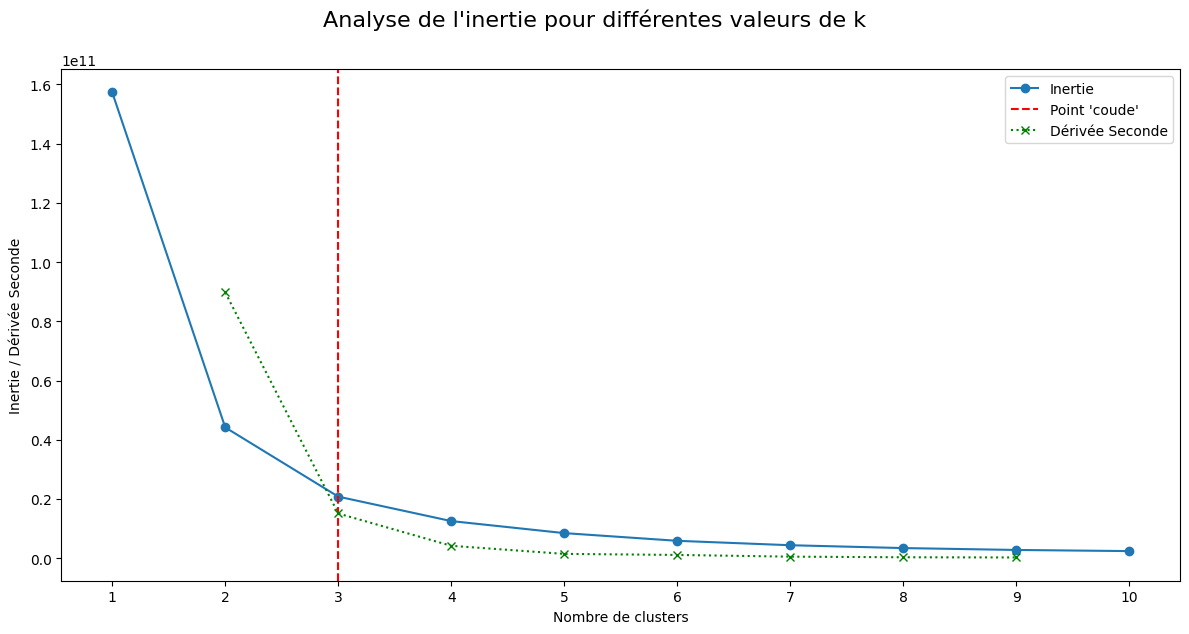

Le nombre optimal de clusters est:  3


In [18]:
nb_optimal_clusters = nombre_optimal_clusters(DataProduits)

On rajoute une colonne "cluster" dans notre DataFrame

In [19]:
DataProduits = clustering_kmeans(DataProduits, nb_optimal_clusters)

# Reduction colonnes avec la méthode ACP

On va plot les composantes principales pour voir si on peut simplifier nos colonnes

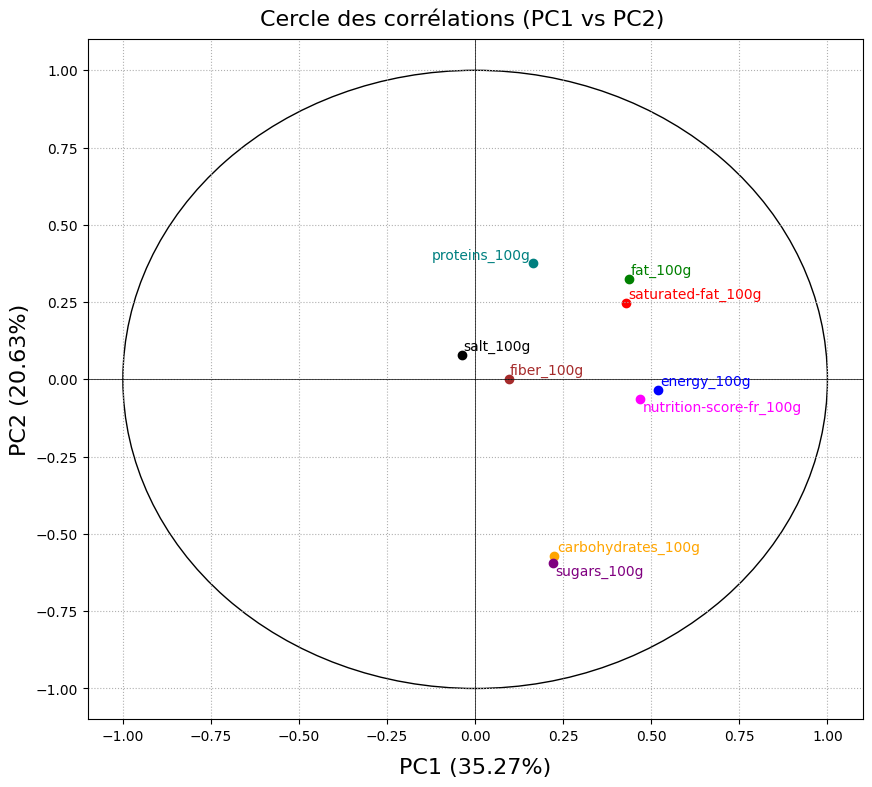

,PC1,PC2
energy_100g,0.519926,-0.033379
nutrition-score-fr_100g,0.467020,-0.061987
fat_100g,0.438144,0.324476
saturated-fat_100g,0.427673,0.248428
carbohydrates_100g,0.225107,-0.571359
sugars_100g,0.221663,-0.595455
proteins_100g,0.163058,0.375264
fiber_100g,0.094840,0.001610
salt_100g,-0.036125,0.078729


In [20]:
plot_PCA(DataProduits, 1, 2)

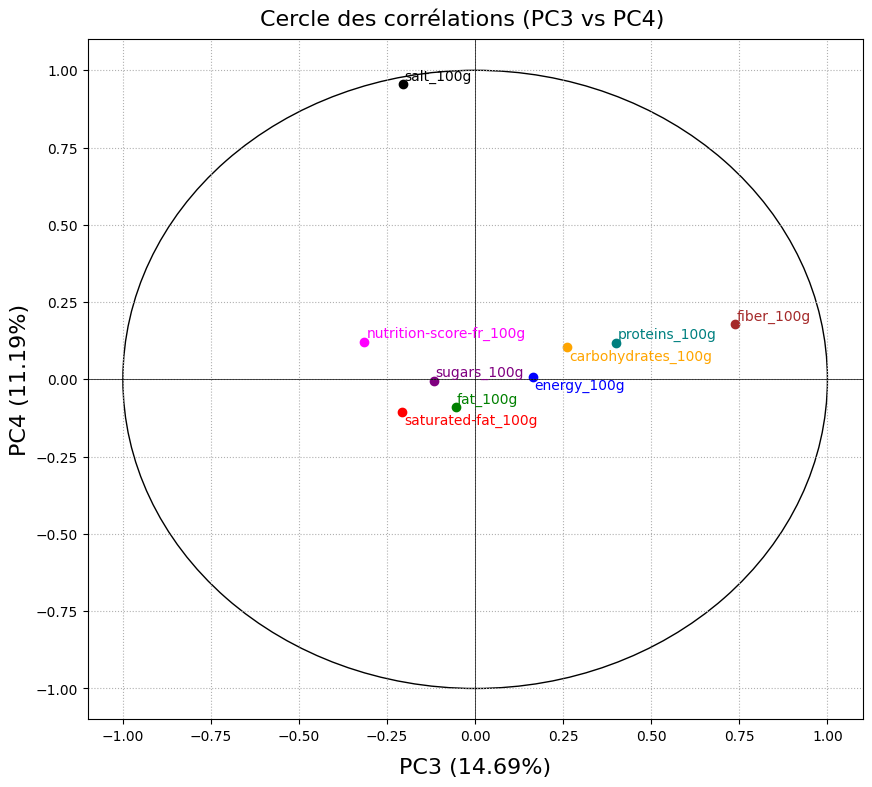

,PC3,PC4
fiber_100g,0.738052,0.178149
proteins_100g,0.398697,0.116936
carbohydrates_100g,0.259887,0.103210
energy_100g,0.164336,0.008566
fat_100g,-0.054492,-0.090488
sugars_100g,-0.116402,-0.004532
salt_100g,-0.205091,0.954118
saturated-fat_100g,-0.208819,-0.104342
nutrition-score-fr_100g,-0.315572,0.120107


In [21]:
plot_PCA(DataProduits, 3, 4)

# OPTION 1

- Pour PC1, on va le renommer "Taux de gras" 
- Pour PC2, on va la renommer "Taux de glucide"
- On inversera le signe de PC2 pour que plus la valeur est élevée, plus le taux de glucide est élevé
- Il n'y aura pas de PC3 et PC4 puisqu'ils ne sont corrélés qu'a une seule colonne

On aura donc les colonnes suivantes : 
- PC1 = Taux de gras
- PC2 = Taux de glucide
- energy_100g = Apport énergétique
- nutrion-score-fr_100g = Nutriscore
- fiber_100g = Taux de fibre
- salt_100g = Taux de sel
- proteins_100g = Taux de protéine

In [22]:
df_pca = ajouter_colonnes_PCA(DataProduits)

In [23]:
df_pca= modif(df_pca,"rename", "PCA1", "Taux de gras")
df_pca= modif(df_pca,"rename", "PCA2", "Taux de glucide")
df_pca= modif(df_pca,"rename", "fiber_100g", "Taux de fibre")
df_pca= modif(df_pca,"rename", "salt_100g", "Taux de sel")
df_pca= modif(df_pca,"rename", "proteins_100g", "Taux de protéine")
df_pca= modif(df_pca,"rename", "nutrition-score-fr_100g", "Nutriscore")
df_pca= modif(df_pca,"rename", "energy_100g", "Apport énergétique")

df_pca= modif(df_pca,"invert_sign", "Taux de glucide")

df_pca= modif(df_pca, "erase", "fat_100g")
df_pca= modif(df_pca, "erase", "saturated-fat_100g")
df_pca= modif(df_pca, "erase", "sugars_100g")
df_pca= modif(df_pca, "erase", "carbohydrates_100g")

La colonne PCA1 a été renommée en Taux de gras dans le dataframe.
La colonne PCA2 a été renommée en Taux de glucide dans le dataframe.
La colonne fiber_100g a été renommée en Taux de fibre dans le dataframe.
La colonne salt_100g a été renommée en Taux de sel dans le dataframe.
La colonne proteins_100g a été renommée en Taux de protéine dans le dataframe.
La colonne nutrition-score-fr_100g a été renommée en Nutriscore dans le dataframe.
La colonne energy_100g a été renommée en Apport énergétique dans le dataframe.
Les valeurs de la colonne Taux de glucide ont été multipliées par -1.
La colonne fat_100g a été supprimée du dataframe.
La colonne saturated-fat_100g a été supprimée du dataframe.
La colonne sugars_100g a été supprimée du dataframe.
La colonne carbohydrates_100g a été supprimée du dataframe.


In [24]:
df_pca

,cluster,code,url,creator,created_datetime,last_modified_datetime,product_name,quantity,packaging,brands,categories_fr,origins,manufacturing_places,labels_fr,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries_fr,ingredients_text,allergens,traces_fr,serving_size,additives_fr,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,image_url,image_small_url,Apport énergétique,Taux de fibre,Taux de protéine,Taux de sel,Nutriscore,Taux de gras,Taux de glucide
0,2,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,2017-03-09T14:32:37Z,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,28 g (1 ONZ),NaN,NaN,NaN,d,NaN,NaN,2243.0,3.6,3.57,0.000000,14.0,1119.778267,-2.964958
1,0,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,2017-03-09T14:32:37Z,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,Torn & Glasser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,28 g (0.25 cup),NaN,NaN,NaN,b,NaN,NaN,1941.0,7.1,17.86,0.635000,0.0,817.481200,-10.166870
2,2,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,2017-03-09T10:35:31Z,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,Grizzlies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,28 g (0.25 cup),NaN,NaN,NaN,d,NaN,NaN,2540.0,7.1,17.86,1.224280,12.0,1416.084030,51.092413
3,0,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,2017-03-09T10:34:13Z,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,Bob's Red Mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,Organic polenta,NaN,NaN,35 g (0.25 cup),NaN,NaN,NaN,a,NaN,NaN,1552.0,5.7,8.57,0.510000,-2.0,428.511854,-27.045123
4,0,16100,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,2017-03-09T10:34:11Z,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,NaN,NaN,Unfi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,"Rolled oats, grape concentrate, expeller press...",NaN,NaN,52 g (0.5 cup),NaN,NaN,NaN,c,NaN,NaN,1933.0,7.7,13.46,1.006244,6.0,809.528574,-9.299658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263543,0,9847548283004,http://world-fr.openfoodfacts.org/produit/9847...,drmalabar,2015-07-25T09:47:06Z,2015-09-14T13:37:28Z,Tartines craquantes bio au sarrasin,NaN,"Boîte,Carton,Sachet,Plastique",Le Pain des fleurs,"Aliments et boissons à base de végétaux,Alimen...",NaN,France,"Bio,Bio européen,Sans gluten,AB Agriculture Bi...",NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a,http://fr.openfoodfacts.org/images/products/98...,http://fr.openfoodfacts.org/images/products/98...,1643.0,5.9,13.00,0.680000,-4.0,519.441083,-22.023718
263544,1,989898,http://world-fr.openfoodfacts.org/produit/9898...,openfoodfacts-contributors,2016-09-12T15:40:09Z,2016-09-12T15:40:15Z,Test NF App,100gr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Suisse,"Coco, choco",NaN,NaN,NaN,NaN,NaN,NaN,c,NaN,NaN,569.0,1.1,2.10,1.100000,8.0,-554.741469,16.077949
263545,0,9900000000233,http://world-fr.openfoodfacts.org/produit/9900...,kiliweb,2017-04-01T20:52:18Z,2017-04-01T20:52:19Z,Amandes,NaN,NaN,Biosic,NaN,NaN,NaN,"Bio,Bio européen,AB Agriculture Biologique",NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b,NaN,NaN,2406.0,12.2,21.22,0.100000,0.0,1281.303290,36.281827
263546,1,99111250,http://world-fr.openfoodfacts.org/produit/9911...,balooval,2013-04-28T15:30:39Z,2013-06-20T01:09:16Z,Thé vert Earl grey,50 g,"boîte,carton",Lobodis,"Aliments et boissons à base de végétaux,Boisso...",NaN,NaN,"Commerce équitable,Bio,Bio européen,Max Havela...",NaN,NaN,NaN,NaN,NaN,France,"thé vert, arôme naturel bergamote avec autres ...",NaN,NaN,NaN,NaN,NaN,NaN,b,http://fr.openfoodfacts.org/images/product

In [25]:
data = df_pca

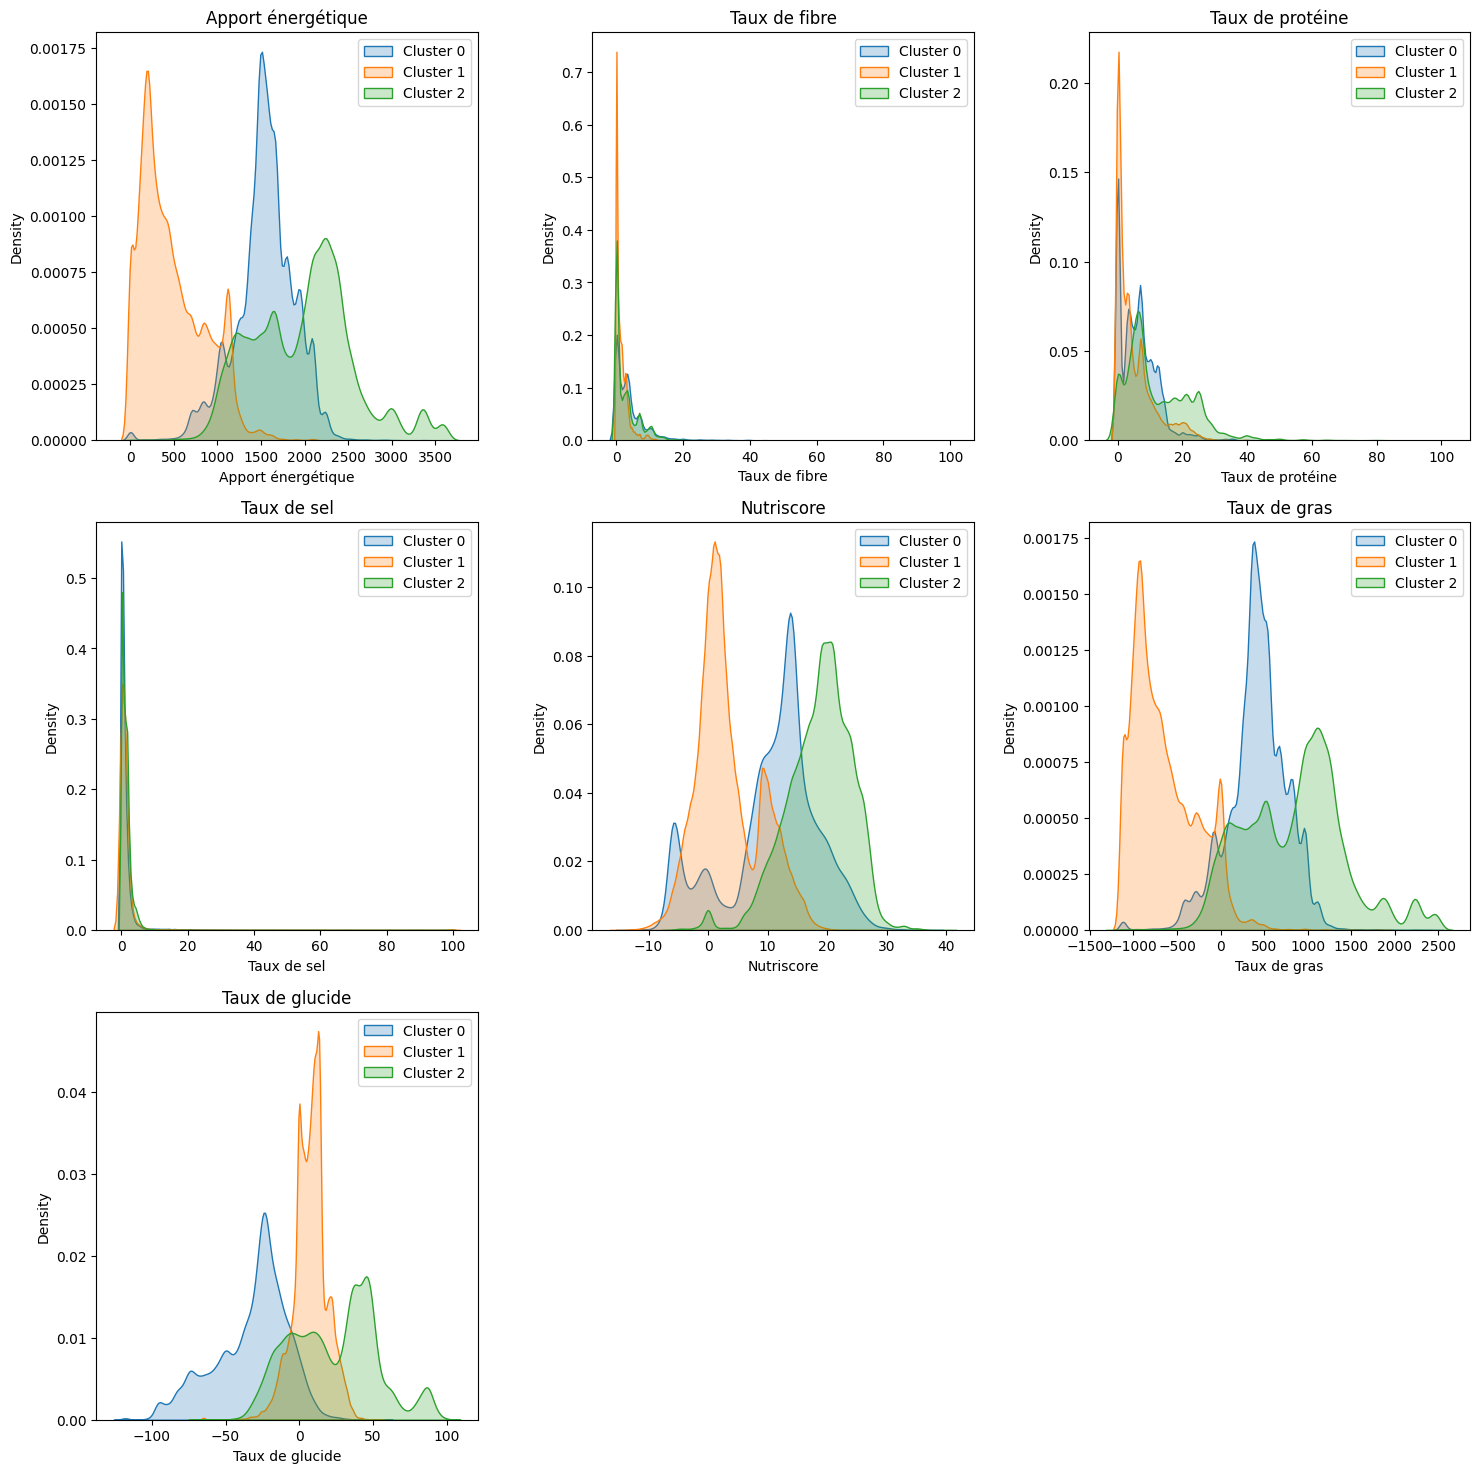

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

# Obtenir le nombre maximum de clusters
max_cluster = data["cluster"].max()

# Filtrer les colonnes de type float
float_columns = data.select_dtypes(include=['float64']).columns

# Calculer la taille de la grille de sous-graphiques
nrows = int(math.ceil(len(float_columns) ** 0.5))
ncols = nrows

# Créer une figure et une grille de sous-graphiques
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
fig.tight_layout(pad=3.0)
fig.subplots_adjust(hspace=0.2, wspace=0.3)

# Parcourir les colonnes de type float
for idx, column in enumerate(float_columns):
    # Calculer la position du sous-graphique dans la grille
    row = idx // ncols
    col = idx % ncols
        
    # Boucle sur les différents clusters
    for i in range(max_cluster + 1):
        # Séparer les données en fonction du cluster
        cluster = data[data["cluster"] == i][column]

        # Créer un histogramme pour le cluster actuel
        sns.kdeplot(cluster, fill=True, label="Cluster " + str(i), ax=axes[row, col])
        
    # Ajouter un titre au sous-graphique
    axes[row, col].set_title(column)
    
    # Ajouter une légende au sous-graphique
    axes[row, col].legend()

# Cacher les graphiques vides
for idx in range(len(float_columns), nrows * ncols):
    row = idx // ncols
    col = idx % ncols
    axes[row, col].set_visible(False)

# Afficher le graphique
plt.show()


A partir de ce graphe, on peut proposer une facon de faire pour filtrer efficacement nos données

Apport énergétique : 
- Faible -> Cluster 1
- Moyenne -> Cluster 0
- Forte -> Cluster 2

Nutriscore : 
- Faible -> Cluster 1
- Moyenne -> Cluster 0
- Forte -> Cluster 2

Taux de gras : 
- Faible -> Cluster 1
- Moyenne -> Cluster 0
- Forte -> Cluster 2

Taux de glucide : 
- Faible -> Cluster 0
- Moyenne -> Cluster 1
- Forte -> Cluster 2


In [27]:
df = DataProduits

In [28]:
import pandas as pd

def filtrage_superficiel(df, criteres, niveau):
    cluster_mapping = {
        "Apport énergétique": {"Faible": 1, "Moyenne": 0, "Forte": 2},
        "Nutriscore": {"Faible": 1, "Moyenne": 0, "Forte": 2},
        "Taux de gras": {"Faible": 1, "Moyenne": 0, "Forte": 2},
        "Taux de glucide": {"Faible": 0, "Moyenne": 1, "Forte": 2}
    }
    
    if criteres in cluster_mapping and niveau in cluster_mapping[criteres]:
        cluster = cluster_mapping[criteres][niveau]
        
        for crit, niveaux in cluster_mapping.items():
            if crit != criteres:
                for niv, clust in niveaux.items():
                    if clust == cluster:
                        print(f"{crit} : {niv}")
        
        df_filtré = df[df['cluster'] == cluster]
        return df_filtré
    else:
        print("Critère ou niveau invalide")
        return None


In [29]:
result = filtrage_superficiel(df, "Apport énergétique", "Faible")
ao(result)

Nutriscore : Faible
Taux de gras : Faible
Taux de glucide : Moyenne
Nombre de lignes:  129032
Nombre de colonnes:  39


,cluster,code,url,creator,created_datetime,last_modified_datetime,product_name,quantity,packaging,brands,categories_fr,origins,manufacturing_places,labels_fr,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries_fr,ingredients_text,allergens,traces_fr,serving_size,additives_fr,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,image_url,image_small_url,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
0,1,3248830085058,http://world-fr.openfoodfacts.org/produit/3248...,dimitri,2013-10-28T19:06:42Z,2017-02-16T14:49:10Z,"Quiche Lorraine Lardons et Jambon fumés, Emmen...",400 g,"Surgelé,Carton",Marie,"Plats préparés,Pizzas tartes salées et quiches...",France,France,"Viande Française,Porc Français",FR 86.160.002 EC,"46.783333,0.183333",mirebeau-vienne-france,Cannes,"Intermarché, Irma.dk","Danemark,France,Suisse","Garniture 69% : eau, _oeufs_ fermier de Loué 1...","oeufs, crème, emmental, blé, blé","Céleri,Crustacés,Poisson,Mollusques,Moutarde",200 g,E471 - Mono- et diglycérides d'acides gras ali...,huile-de-palme,e471-mono-et-diglycerides-d-acides-gras-alimen...,d,http://fr.openfoodfacts.org/images/products/32...,http://fr.openfoodfacts.org/images/products/32...,1073.0,16.0,8.6,18.3,1.3,0.70,9.6,0.86,14.0
1,1,3596710390779,http://world-fr.openfoodfacts.org/produit/3596...,tacite,2015-06-16T15:57:13Z,2015-08-24T19:40:13Z,"Hachis Parmentier, Surgelé",400 g,"Surgelé,Barquette,Plastique,Opercule,Film plas...","Auchan,L'oiseau","Surgelés,Plats préparés,Plats à base de viande...","Viande Bovine,France",Celtigel (Filiale Groupe Le Graët) - ZA des 4 ...,"Viande Française,Produit en braille,Viande Bov...",FR 22.182.001 EC,"48.566667,-2.95",plelo-cotes-d-armor-france,"Noyelles-Godault,France",Auchan,France,"Eau, viande bovine crue 19 %, oignons, flocons...","lait, gluten, lait, lait, lait, lait","Céleri,Crustacés,Œufs,Poisson,Lupin,Mollusques...",400 g (1 barquette) Cet emballage contient l'é...,E471 - Mono- et diglycérides d'acides gras ali...,e304-palmitate-d-ascorbyle,e471-mono-et-diglycerides-d-acides-gras-alimen...,b,http://fr.openfoodfacts.org/images/products/35...,http://fr.openfoodfacts.org/images/products/35...,505.0,5.0,2.4,11.6,2.0,1.30,6.6,0.80,1.0
2,1,3250391414628,http://world-fr.openfoodfacts.org/produit/3250...,openfoodfacts-contributors,2014-02-18T16:39:40Z,2015-05-10T06:54:16Z,Cheeseburger,145 g,"Carton,Boîte,Décongelé",Netto,"Sandwichs,Cheeseburger",France,"Theix,Morbihan,Bretagne,France","Viande Française,Viande Bovine Française",EMB 56251C,"47.633333,-2.666667",theix-morbihan-france,"France,Courrières",netto,France,"Garniture 62,1% : préparation de viande bovine...","lait, lait, moutarde, moutarde, moutarde, blé,...","Crustacés,Œufs,Poisson,Mollusques,Fruits à coque",145 g,"E452 - Polyphosphates,E331 - Citrates de sodiu...",NaN,e471-mono-et-diglycerides-d-acides-gras-alimen...,d,http://fr.openfoodfacts.org/images/products/32...,http://fr.openfoodfacts.org/images/products/32...,1041.0,12.2,5.7,19.8,3.0,1.52,14.1,1.33,13.0


La fonction "trouver_produits_similaires" juste en dessous va prendre en input un produit qu'on aura "scanné" et en output on retournera un dataframe qui possédera des produits similaires à lui, 3 filtres sont appliqués:

-Même cluster ("cluster")  
-Même grade Nutriscore ("nutrition_grade_fr")  
-Possède au moins un terme en commun dans "categories_fr"  

Le dataframe affichera aussi les 1eres lignes comme étant ceux qui possèdent le plus de termes "categories_fr" en commun avec le produit scanné

In [30]:
import pandas as pd

def trouver_produits_similaires(df, code):
    # Trouver la ligne correspondante au code donné
    produit = df[df['code'] == code]
    
    # Vérifier si le code existe dans le dataframe
    if len(produit) == 0:
        print("Le code produit n'a pas été trouvé.")
        return
    
    # Récupérer la valeur du cluster pour ce produit
    cluster = produit.iloc[0]['cluster']
    
    # Récupérer la valeur du 'nutrition_grade_fr' pour ce produit
    nutrition_grade = produit.iloc[0]['nutrition_grade_fr']

    # Créer un dictionnaire avec les caractéristiques et leurs valeurs de cluster correspondantes
    caracteristiques = {
        "Apport énergétique": {1: "Faible", 0: "Moyenne", 2: "Forte"},
        "Nutriscore": {1: "Faible", 0: "Moyenne", 2: "Forte"},
        "Taux de gras": {1: "Faible", 0: "Moyenne", 2: "Forte"},
        "Taux de glucide": {0: "Faible", 1: "Moyenne", 2: "Forte"}
    }
  
    # Afficher les informations en fonction du cluster
    for caract, valeurs in caracteristiques.items():
        print(f"{caract} : {valeurs[cluster]}")
    
    # Sélectionner les lignes ayant le même cluster et le même 'nutrition_grade_fr'
    produits_similaires = df[(df['cluster'] == cluster) & (df['nutrition_grade_fr'] == nutrition_grade)]
    
    # Extraire les termes de categories_fr du produit recherché
    if isinstance(produit.iloc[0]['categories_fr'], str):
        categories_fr = set(produit.iloc[0]['categories_fr'].split(','))

    # Filtrer les produits similaires qui contiennent au moins un des termes de packaging
    produits_similaires = produits_similaires[produits_similaires['categories_fr'].apply(lambda x: any(term in str(x).split(',') for term in categories_fr))]
    
    # Ajouter une nouvelle colonne qui compte le nombre de catégories communes
    produits_similaires['categories_common_count'] = produits_similaires['categories_fr'].apply(lambda x: len(categories_fr.intersection(set(str(x).split(',')))))
    
    # Trier le dataframe selon le nombre de catégories communes
    produits_similaires = produits_similaires.sort_values('categories_common_count', ascending=False)
    
    produit_code = df[df['code'] == code]
    display(produit_code)
    
    return produits_similaires


In [31]:
result = trouver_produits_similaires(df, code = 20427634)
result

Apport énergétique : Faible
Nutriscore : Faible
Taux de gras : Faible
Taux de glucide : Moyenne


,cluster,code,url,creator,created_datetime,last_modified_datetime,product_name,quantity,packaging,brands,categories_fr,origins,manufacturing_places,labels_fr,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries_fr,ingredients_text,allergens,traces_fr,serving_size,additives_fr,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,image_url,image_small_url,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
170458,1,20427634,http://world-fr.openfoodfacts.org/produit/2042...,sebleouf,2014-04-27T10:24:39Z,2015-07-23T16:08:33Z,2 panés au colin d'Alaska,200 g (2 x 100 g),"Frais,Barquette,Plastique,Opercule,Film plasti...","Atlantic,Lidl Stiftung & Co. KG","Frais,Plats préparés,Produits panés,Poissons p...",Colin d'Alaska,Cité Marine - Carrefour Industriel du Porzo - ...,"Point Vert,Eco-emballages",FR 56.094.004 EC,"47.766667,-3.233333",kervignac-morbihan-france,"Lyon,France",Lidl,France,Préparation à base de colin d'Alaska 70 % : _c...,"colin, calamar, blé, blé","Œufs,Lait",100 g (Cette barquette contient 2 portions de ...,"E14XX - Amidons modifiés,E461 - Méthylcellulos...",NaN,huile-vegetale,a,http://fr.openfoodfacts.org/images/products/20...,http://fr.openfoodfacts.org/images/products/20...,840.0,8.8,0.7,18.5,0.8,0.8,11.4,0.635,-2.0


,cluster,code,url,creator,created_datetime,last_modified_datetime,product_name,quantity,packaging,brands,categories_fr,origins,manufacturing_places,labels_fr,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries_fr,ingredients_text,allergens,traces_fr,serving_size,additives_fr,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,image_url,image_small_url,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g,categories_common_count
170458,1,20427634,http://world-fr.openfoodfacts.org/produit/2042...,sebleouf,2014-04-27T10:24:39Z,2015-07-23T16:08:33Z,2 panés au colin d'Alaska,200 g (2 x 100 g),"Frais,Barquette,Plastique,Opercule,Film plasti...","Atlantic,Lidl Stiftung & Co. KG","Frais,Plats préparés,Produits panés,Poissons p...",Colin d'Alaska,Cité Marine - Carrefour Industriel du Porzo - ...,"Point Vert,Eco-emballages",FR 56.094.004 EC,"47.766667,-3.233333",kervignac-morbihan-france,"Lyon,France",Lidl,France,Préparation à base de colin d'Alaska 70 % : _c...,"colin, calamar, blé, blé","Œufs,Lait",100 g (Cette barquette contient 2 portions de ...,"E14XX - Amidons modifiés,E461 - Méthylcellulos...",NaN,huile-vegetale,a,http://fr.openfoodfacts.org/images/products/20...,http://fr.openfoodfacts.org/images/products/20...,840.0,8.8,0.700,18.50,0.80,0.80,11.40,0.635000,-2.0,6
209485,1,3492500049486,http://world-fr.openfoodfacts.org/produit/3492...,phoenix,2016-05-31T16:17:16Z,2016-06-03T17:24:18Z,Portions au Poisson Pané,400 g (x 4),"Barquette,Sous atmosphère protectrice,Plastique",Sans Marque,"Frais,Plats préparés,Produits panés,Poissons p...",NaN,"France,Bretagne,Morbihan",NaN,FR 56.094.004 EC,"47.766667,-3.233333",kervignac-morbihan-france,"Rennes,France",Carrefour,France,Préparation à base de poisson 70% : _poisson_ ...,"poisson, calamar, oeuf, blé, blé",Lait,NaN,"E14XX - Amidons modifiés,E461 - Méthylcellulos...",NaN,huile-vegetale,a,NaN,NaN,844.0,8.6,0.920,19.60,1.06,1.04,10.90,0.780000,-1.0,5
209483,1,3492500046805,http://world-fr.openfoodfacts.org/produit/3492...,phoenix,2016-05-06T09:42:26Z,2016-05-06T17:29:43Z,Filets de Colin d'Alaska Panés,220 g (x 2),"Barquette,Plastique,Sous atmosphère protectrice",Cité Marine,"Frais,Plats préparés,Produits panés,Poissons p...",NaN,"France,Bretagne","Peu ou pas de matière grasse,Peu de matière gr...",FR 56.094.004 EC,"47.766667,-3.233333",kervignac-morbihan-france,"Rennes,France",Carrefour,France,Filets de _colin_ d'Alaska 65%. Enrobage 35% :...,"colin, blé, blé, gluten, blé","Œufs,Lait,Mollusques",NaN,NaN,NaN,huile-vegetale,a,http://fr.openfoodfacts.org/images/products/34...,http://fr.openfoodfacts.org/images/products/34...,886.0,8.9,0.800,20.60,0.80,1.10,11.60,0.460000,-2.0,5
209467,1,3492500033850,http://world-fr.openfoodfacts.org/produit/3492...,phoenix,2016-05-06T09:41:00Z,2016-05-06T17:12:56Z,Panés au Colin d'Alaska,500 g (x 5),"Barquette,Plastique,Sous atmosphère protectrice",Cité Marine,"Frais,Plats préparés,Produits panés,Poissons p...",NaN,France,"Peu ou pas de matière grasse,Sans matière gras...",FR 56.094.004 EC,"47.766667,-3.233333",kervignac-morbihan-france,"Rennes,France",Carrefour,France,Préparation à base de _colin_ d'Alaska 70% : c...,"colin, calamar, blé, blé","Œufs,Lait",NaN,"E14XX - Amidons modifiés,E461 - Méthylcellulos...",NaN,huile-vegetale,a,http://fr.openfoodfacts.org/images/products/34...,http://fr.openfoodfacts.org/images/products/34...,840.0,8.8,0.700,18.50,0.80,0.80,11.40,0.620000,-2.0,5
209484,1,3492500048816,http://world-fr.openfoodfacts.org/produit/3492...,phoenix,2016-05-06T09:41:43Z,2017-01-13T11:57:51Z,Petits poissons panés,180 g,"Barquette,Plastique,Sous atmosphère protectric...",Cité Marine,"Frais,Plats préparés,Produits panés,Poissons p...",NaN,France,"Sans-ajout-de-matiere-grassse,Sans-arete",FR 56.094.004 EC,"47.766667,-3.233333",kervignac-morbihan-france,"Rennes,France",Carrefour,France,Préparation à base de _c

# Test ANOVA (annulé)

L'ANOVA, ou analyse de la variance, est une méthode statistique utilisée pour comparer les moyennes de deux groupes ou plus afin de déterminer si elles sont significativement différentes les unes des autres. Le terme "variance" dans ANOVA se réfère à la variabilité entre les groupes comparés.

Pour réaliser un test ANOVA, certaines conditions doivent être remplies :

**Indépendance des observations :** Les observations doivent être indépendantes les unes des autres. En d'autres termes, la présence ou l'absence de chaque observation ne doit pas affecter les autres observations.

**Normalité :** Les données de chaque groupe doivent suivre une distribution normale (test de Kolmogorov-Smirnov pour n>5000)

**Homogénéité de la variance :** Les variances des populations dont proviennent les différents groupes doivent être égales. On peut tester cette hypothèse avec le test de Levene ou de Bartlett, par exemple.

## Test Normalité

In [19]:
import pandas as pd
from scipy import stats

def test_normality(df):
    # Sélectionner les colonnes quantitatives du dataframe
    quant_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Parcourir les colonnes quantitatives et effectuer le test de normalité
    for col in quant_cols:
        data = df[col].dropna()  # Éliminer les valeurs manquantes
        
        # Effectuer le test de normalité de Kolmogorov-Smirnov
        stat, p = stats.kstest(data, 'norm')
        
        # Interprétation des résultats du test
        alpha = 0.05  # Niveau de signification
        print(f"Colonne : {col}")
        print(f"Statistique de test : {stat}")
        print(f"p-value : {p}")
        if p > alpha:
            print("La distribution semble normale (accepter H0)")
        else:
            print("La distribution ne semble pas normale (rejeter H0)")
        print("-----------------------------------")

# Exemple d'utilisation
# Supposons que votre dataframe s'appelle "df"
test_normality(DataProduits[DataProduits['cluster'] ==0])


Colonne : energy_100g
Statistique de test : 0.9997838640412364
p-value : 0.0
La distribution ne semble pas normale (rejeter H0)
-----------------------------------
Colonne : fat_100g
Statistique de test : 0.9832053743053701
p-value : 0.0
La distribution ne semble pas normale (rejeter H0)
-----------------------------------
Colonne : saturated-fat_100g
Statistique de test : 0.9745730114916739
p-value : 0.0
La distribution ne semble pas normale (rejeter H0)
-----------------------------------
Colonne : carbohydrates_100g
Statistique de test : 0.7789392480093459
p-value : 0.0
La distribution ne semble pas normale (rejeter H0)
-----------------------------------
Colonne : sugars_100g
Statistique de test : 0.6111041744644852
p-value : 0.0
La distribution ne semble pas normale (rejeter H0)
-----------------------------------
Colonne : fiber_100g
Statistique de test : 0.5
p-value : 0.0
La distribution ne semble pas normale (rejeter H0)
-----------------------------------
Colonne : proteins_10

Les colonnes (cluster 0) n'ont pas de distribution normale -> On ne peut pas effectuer les test ANOVA